In [65]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pypfopt.efficient_frontier import EfficientFrontier
%matplotlib inline
# portfolio optimizationのライブラリを使用
# https://pyportfolioopt.readthedocs.io/en/latest/

In [77]:
assetName = ['AUL','CAN','FRA','GER','JAP','UKG','USA']
# 相関行列
correlation = np.array([
        [1, 0.488, 0.478, 0.515, 0.439, 0.512, 0.491],
        [0.488, 1, 0.664, 0.655, 0.310, 0.608, 0.779],
        [0.478, 0.664, 1, 0.861, 0.355, 0.783, 0.668],
        [0.515, 0.655, 0.861, 1, 0.354, 0.777, 0.653],
        [0.439, 0.310, 0.355, 0.354, 1, 0.405, 0.306],
        [0.512, 0.608, 0.783, 0.777, 0.405, 1, 0.652],
        [0.491, 0.779, 0.668, 0.653, 0.306, 0.652, 1]])
# 標準偏差
std = np.array([[0.16, 0.203, 0.248, 0.271, 0.21, 0.2, 0.187]])
# 相関行列と標準偏差から共分散行列を計算
Sigma = correlation * np.dot(std.T, std)
Sigma = pd.DataFrame(Sigma, index = assetName, columns=assetName)

In [78]:
# リスクベースポートフォリオの作成
# 分散最小化
min_risk_weight = EfficientFrontier(None, Sigma).min_volatility()

In [79]:
# リスクベースポートフォリオを基に、Black Littermanを適用する
# パラメータdelta, tai  値はHe&Litterman(1999)に従う
delta = 2.5
tau = 0.05
# 均衡リターンを求める(reverse optimization)
# ↑つまり、共分散行列とポートフォリオのweightから、期待収益を推定するという事
r_eq = np.asmatrix(delta * np.dot(Sigma, np.array(list(min_risk_weight.values()), dtype="float"))).T

In [80]:
# 見通しの作成
P = np.array([
        [0,0,-0.295,1,0,-0.705,0],
        [0,1,0,0,0,0,-1]]) # 2x7 matrix (2: number of views, 7: number of assets)
Q = np.array([[0.05],[0.03]]) # 2-vector
Omega = np.array([
        [0.001065383332,0],
        [0,0.0008517381]])

In [81]:
# 見通しの反映
# 期待収益率に反映
r_posterior = r_eq + np.dot( np.dot( tau*np.dot(Sigma,P.T), np.linalg.inv(tau*np.dot(np.dot(P,Sigma),P.T)+Omega)), (Q-np.dot(P,r_eq)))
# 共分散行列の反映
Sigma_posterior = Sigma + tau*Sigma - tau*np.dot( np.dot( np.dot(Sigma,P.T), np.linalg.inv(tau*np.dot(np.dot(P,Sigma),P.T)+Omega)), tau*np.dot(P,Sigma))

In [84]:
# Forward Optimizationをして最適ウェイトを求める
w_posterior = np.dot(np.linalg.inv(delta*Sigma_posterior), r_posterior)

<AxesSubplot:>

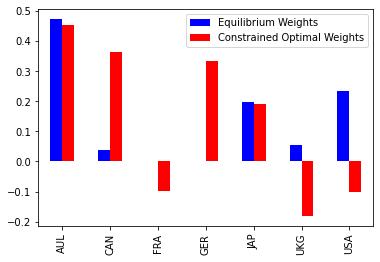

In [104]:
df = pd.DataFrame([min_risk_weight.values(),np.asarray(w_posterior).flatten()],
                  columns=assetName,
                  index=['Equilibrium Weights','Constrained Optimal Weights'])
df.T.plot(kind='bar', color='br')

array([ 0.4510335 ,  0.36172645, -0.09820511,  0.33289868,  0.18918707,
       -0.18188964, -0.10236999])

In [62]:
r_eq.T.T

array([0.05002065, 0.05002065, 0.05835142, 0.06509754, 0.05002065,
       0.05002065, 0.05002065])